# Initialisation SparkSession

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("News_Preprocessing") \
    .master("spark://spark-master:7077") \
    .getOrCreate()


# Charger les données depuis HDFS

In [60]:
df = spark.read.csv(
    "hdfs://namenode:8020/raw/dataset/data.csv",
    header=True,
    inferSchema=True
)



In [61]:
df.show(5)
df.printSchema()


+-----------+---------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|source_type|   source|               title|                link|          published|             summary|           news_type|        content_hash|      retrieved_date|
+-----------+---------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        rss|  BBC_Top|Sultana says part...|https://www.bbc.c...|2025-10-31T10:35:39|"Changing ""peopl...| the Coventry Sou...|          technology|3689426e5694f6da8...|
|        rss|TechRadar|"Amazon CEO says ...|https://www.techr...|2025-10-31T11:24:00|Amazon CEO Andy J...|          technology|3d812c99914ef3240...|2025-10-31T12:26:...|
|        rss|TechRadar|Are AMD GPUs no l...|https://www.techr...|2025-10-31T11:23:02|Has AMD stopped s...|              sports|614c3950705785942...|20

# Nombre de lignes & colonnes

In [62]:
print("Rows:", df.count())
print("Columns:", len(df.columns))
df.columns


Rows: 38976
Columns: 9


['source_type',
 'source',
 'title',
 'link',
 'published',
 'summary',
 'news_type',
 'content_hash',
 'retrieved_date']

# Vérifier les doublons

In [63]:
dups = df.count() - df.dropDuplicates().count()
print("Duplicate rows:", dups)


Duplicate rows: 131


### Suppression des doublons basés sur content_hash 

In [64]:
df = df.dropDuplicates(["content_hash"])


# Analyse des valeurs manquantes

In [65]:
from pyspark.sql.functions import col, sum

df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()


+-----------+------+-----+----+---------+-------+---------+------------+--------------+
|source_type|source|title|link|published|summary|news_type|content_hash|retrieved_date|
+-----------+------+-----+----+---------+-------+---------+------------+--------------+
|          0|     0|    2|5975|    10606|      2|     5257|           1|            33|
+-----------+------+-----+----+---------+-------+---------+------------+--------------+



# Traitement des valeurs manquantes

In [66]:
from pyspark.sql.functions import coalesce, col

df = df.withColumn(
    "published_filled",
    coalesce(col("published"), col("retrieved_date"))
)

df = df.fillna({"news_type": "unknown", "link": "unknown"})


# Harmoniser le format des dates

In [67]:
from pyspark.sql.functions import regexp_replace, to_timestamp

df = df.withColumn(
    "published_ts",
    to_timestamp(regexp_replace("published_filled", "T", " "), "yyyy-MM-dd HH:mm:ss")
)


# Créer la colonne texte combinée (title + summary)

In [68]:
from pyspark.sql.functions import concat_ws

df = df.withColumn(
    "text",
    concat_ws(" ", col("title"), col("summary"))
)


# Nettoyage du texte

In [69]:
from pyspark.sql.functions import lower, regexp_replace, trim

df = df.withColumn(
    "text_clean",
    lower(regexp_replace(col("text"), "[^a-zA-Z0-9\\s]", " "))
)

df = df.withColumn(
    "text_clean",
    regexp_replace("text_clean", "\\s+", " ")
)

df = df.withColumn("text_clean", trim("text_clean"))


# Tokenisation

# Retirer les stopwords

In [70]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

tokenizer = Tokenizer(inputCol="text_clean", outputCol="tokens")
df = tokenizer.transform(df)

remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df = remover.transform(df)


# (Optionnel) TF-IDF pour ML plus tard

In [71]:
from pyspark.ml.feature import HashingTF, IDF

hashingTF = HashingTF(inputCol="filtered_tokens", outputCol="rawFeatures", numFeatures=20000)
df_tf = hashingTF.transform(df)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(df_tf)
df_tfidf = idfModel.transform(df_tf)


In [72]:
df_clean = df
df_clean = df_clean.dropna()


# Sauvegarder les données preprocessées dans HDFS

In [73]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

df_clean.write.mode("overwrite").parquet("hdfs://namenode:8020/user/jovyan/cleansed/news_preprocessed/")


In [74]:
df_clean.show(5)
df_clean.printSchema()


+-----------+--------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|source_type|        source|               title|                link|          published|             summary|           news_type|        content_hash|      retrieved_date|   published_filled|       published_ts|                text|          text_clean|              tokens|     filtered_tokens|
+-----------+--------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|        rss|      France24|Yann Arthus-Bertr...|https://www.franc...|2025-10-28T14:15:53|"Il a longtem

In [76]:
from pyspark.sql.functions import col, sum

df_nulls = df_clean.select([
    sum(col(c).isNull().cast("int")).alias(c) for c in df_clean.columns
])

df_nulls.show()


+-----------+------+-----+----+---------+-------+---------+------------+--------------+----------------+------------+----+----------+------+---------------+
|source_type|source|title|link|published|summary|news_type|content_hash|retrieved_date|published_filled|published_ts|text|text_clean|tokens|filtered_tokens|
+-----------+------+-----+----+---------+-------+---------+------------+--------------+----------------+------------+----+----------+------+---------------+
|          0|     0|    0|   0|        0|      0|        0|           0|             0|               0|           0|   0|         0|     0|              0|
+-----------+------+-----+----+---------+-------+---------+------------+--------------+----------------+------------+----+----------+------+---------------+



In [77]:
print("Before:", df.count())
print("After:", df_clean.count())


Before: 34111
After: 22273


# EDA TEXTUELLE & STATISTIQUE (TABLEAUX / ANALYSE)

In [82]:
from pyspark.sql.functions import length

df_clean.select(
    length("text_clean").alias("text_length")
).describe().show()


+-------+------------------+
|summary|       text_length|
+-------+------------------+
|  count|             22273|
|   mean|253.55030754725453|
| stddev|125.83174784680315|
|    min|                16|
|    max|               645|
+-------+------------------+



In [83]:
from pyspark.sql.functions import explode

df_clean.select(explode("filtered_tokens").alias("word")) \
    .groupBy("word") \
    .count() \
    .orderBy("count", ascending=False) \
    .show(50)


+-------+-----+
|   word|count|
+-------+-----+
|     de|14101|
|     la| 8967|
|      d| 5903|
|      l| 5517|
|     le| 5396|
|     en| 4684|
|    les| 3456|
|     un| 3345|
|    des| 3232|
|    new| 2890|
|     et| 2735|
|     el| 2455|
|     du| 2388|
|      n| 2220|
|      e| 2163|
|    que| 2149|
|    une| 1975|
|      r| 1883|
|  trump| 1772|
|   pour| 1651|
|   dans| 1629|
|      y| 1517|
|     au| 1508|
|   year| 1472|
|    sur| 1453|
|   says| 1442|
|    one| 1419|
|     ai| 1401|
|   2025| 1329|
|      m| 1302|
|      1| 1286|
|     us| 1265|
|     re| 1246|
|  first| 1241|
|  world| 1189|
|    est| 1187|
|     pr| 1122|
|    los| 1093|
|    two| 1087|
|    par| 1087|
|     se| 1083|
|      2| 1072|
|summary| 1070|
|    del| 1031|
|    qui|  981|
|   best|  961|
|     es|  961|
|      u|  940|
|   said|  935|
|     ce|  926|
+-------+-----+
only showing top 50 rows



## Convertir une petite partie du dataset pour les graphes

In [85]:
pdf = df_clean.sample(fraction=0.15).toPandas()


# Visualisation : distributions, tendances, catégories

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")


## Distribution des sources médiatiques (top 15)

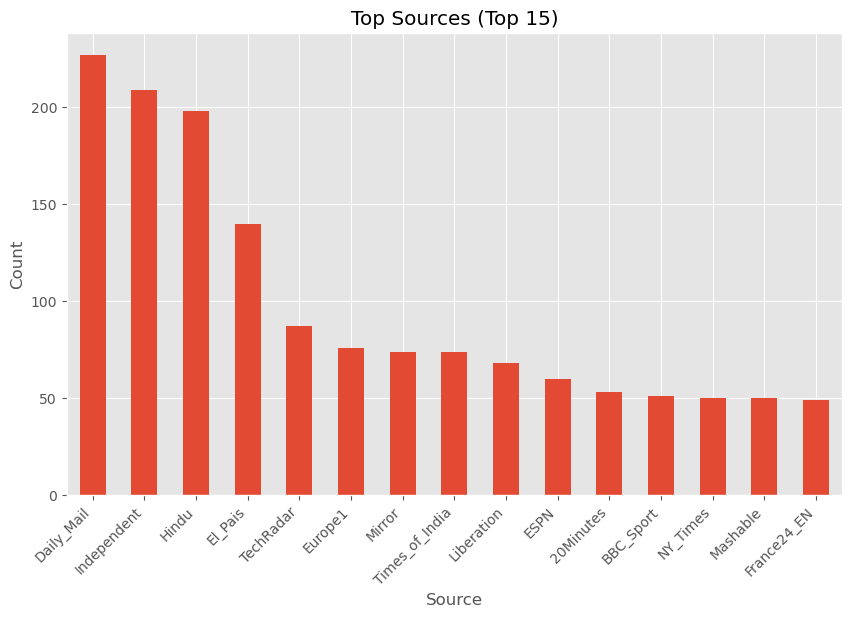

In [87]:
plt.figure(figsize=(10,6))
pdf['source'].value_counts().head(15).plot(kind='bar')
plt.title("Top Sources (Top 15)")
plt.xlabel("Source")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()


## Distribution des catégories (news_type)

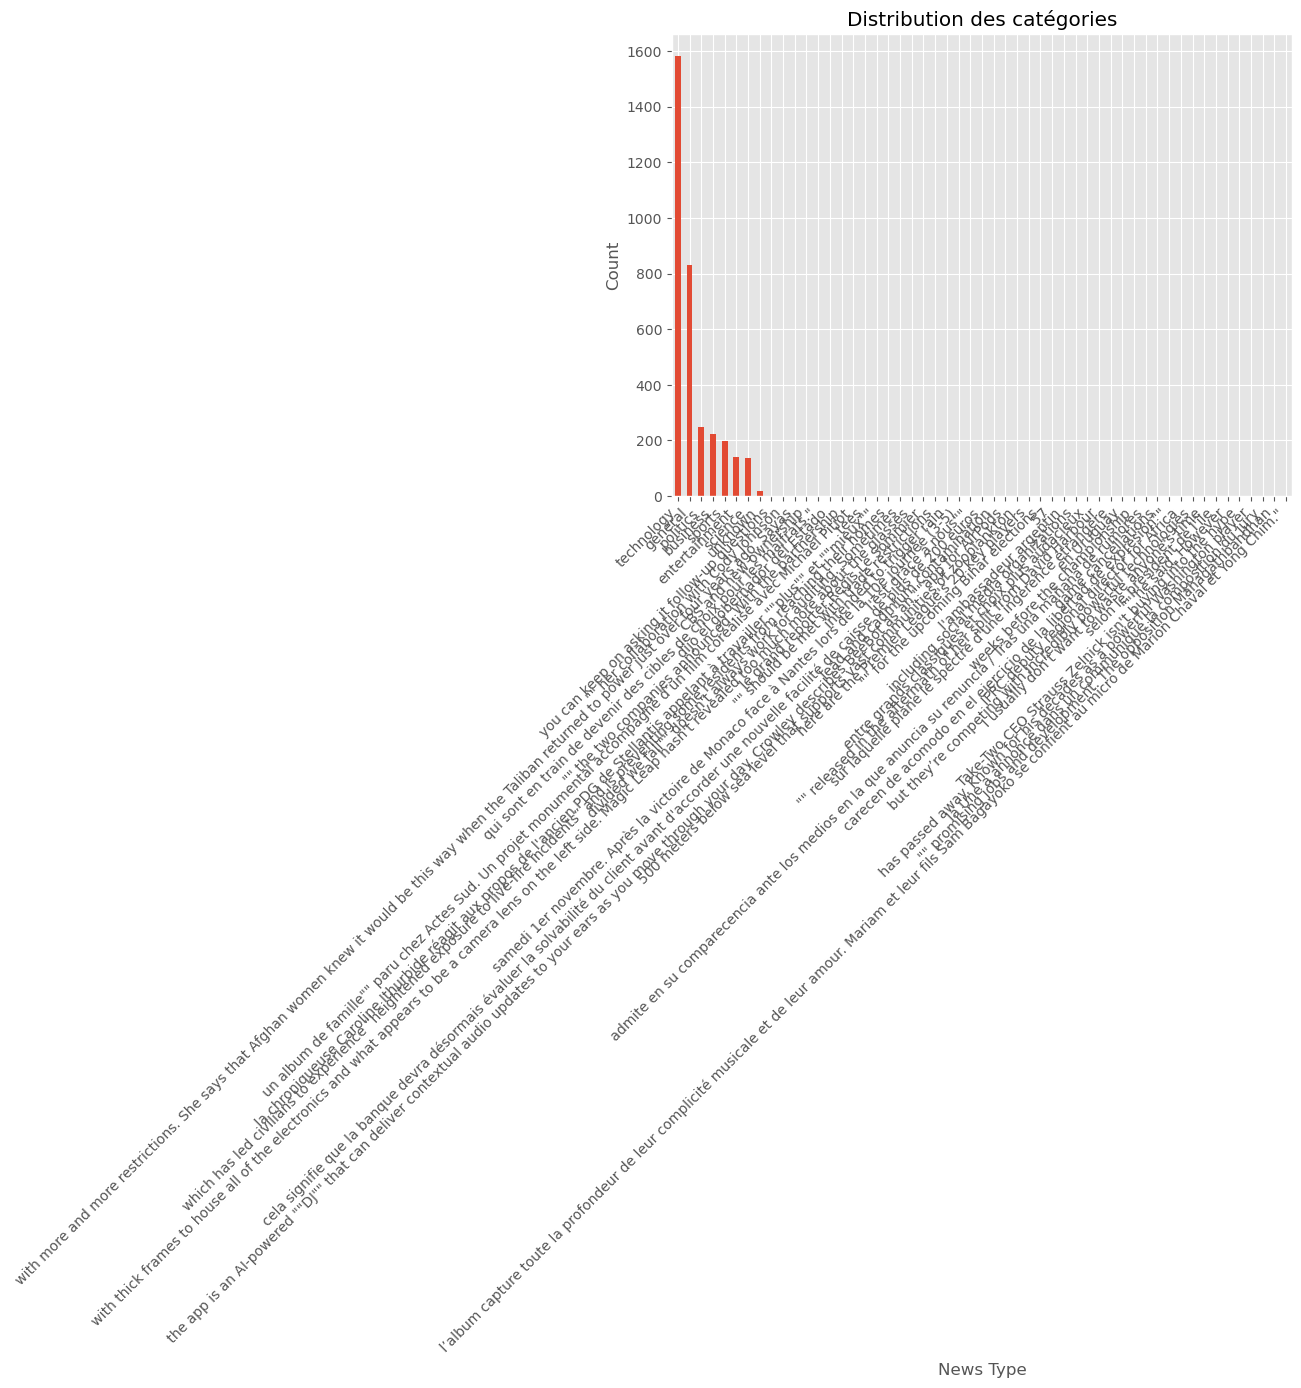

In [88]:
plt.figure(figsize=(8,6))
pdf['news_type'].value_counts().plot(kind='bar')
plt.title("Distribution des catégories")
plt.xlabel("News Type")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.show()


## Distribution temporelle (nombre d’articles par mois)

In [89]:
pdf['date_ym'] = pdf['published_ts'].dt.to_period('M')


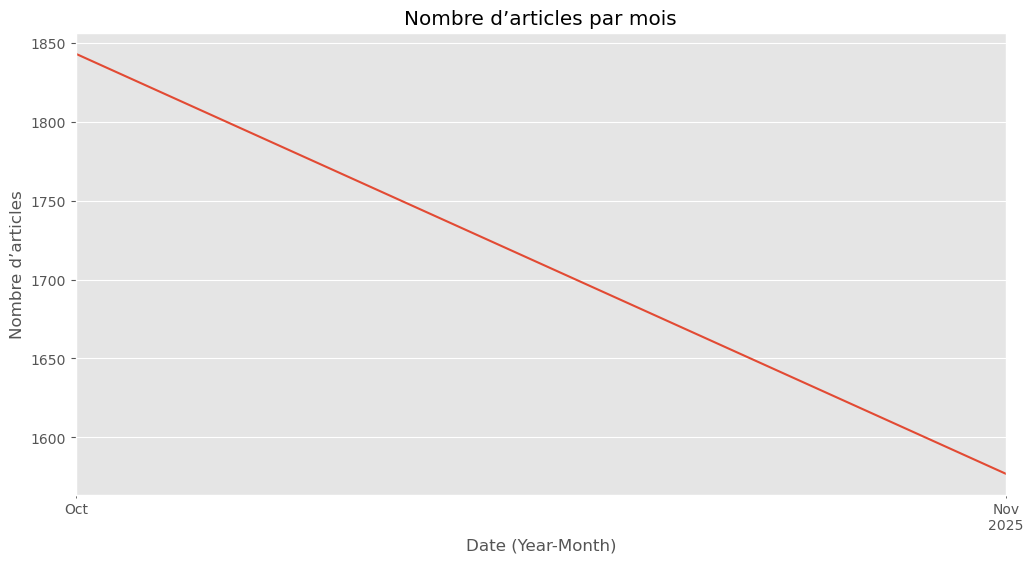

In [90]:
plt.figure(figsize=(12,6))
pdf['date_ym'].value_counts().sort_index().plot(kind='line')
plt.title("Nombre d’articles par mois")
plt.xlabel("Date (Year-Month)")
plt.ylabel("Nombre d’articles")
plt.xticks(rotation=45)
plt.show()


## ️Longueur des textes (analyse qualité du contenu)

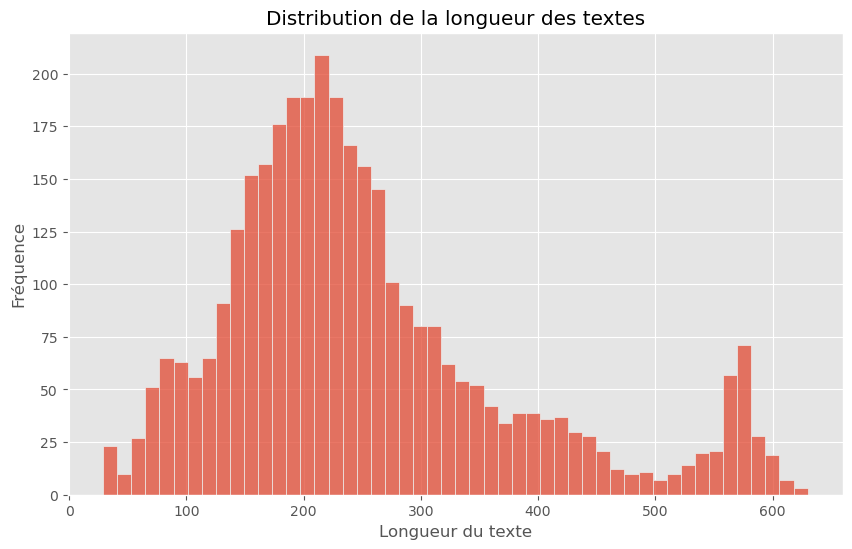

In [91]:
pdf['text_length'] = pdf['text_clean'].astype(str).apply(len)

plt.figure(figsize=(10,6))
sns.histplot(pdf['text_length'], bins=50)
plt.title("Distribution de la longueur des textes")
plt.xlabel("Longueur du texte")
plt.ylabel("Fréquence")
plt.show()


## Wordcloud des mots les plus fréquents

In [92]:
!pip install wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 1.1 MB/s eta 0:00:0000:01:00:01


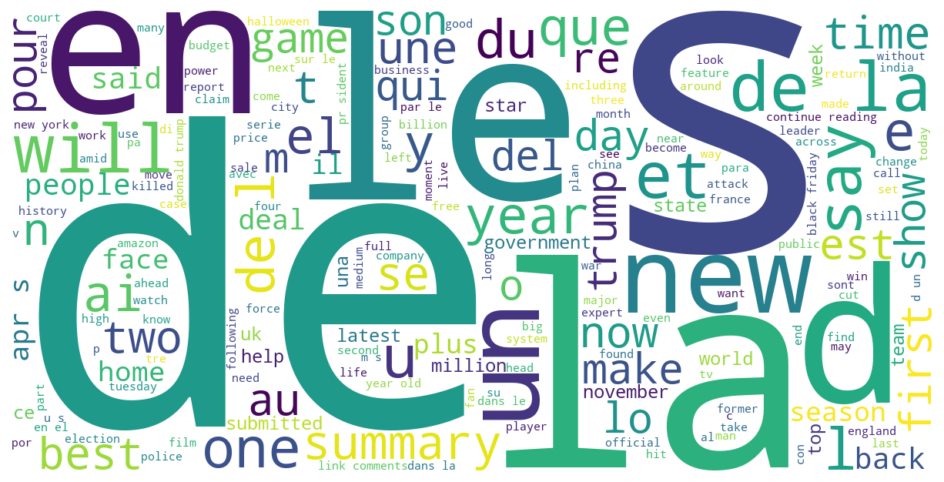

In [93]:
from wordcloud import WordCloud

text_all = " ".join(pdf['text_clean'].astype(str).tolist())

wordcloud = WordCloud(width=1200, height=600, background_color='white').generate(text_all)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


## Heatmap des top sources vs catégories

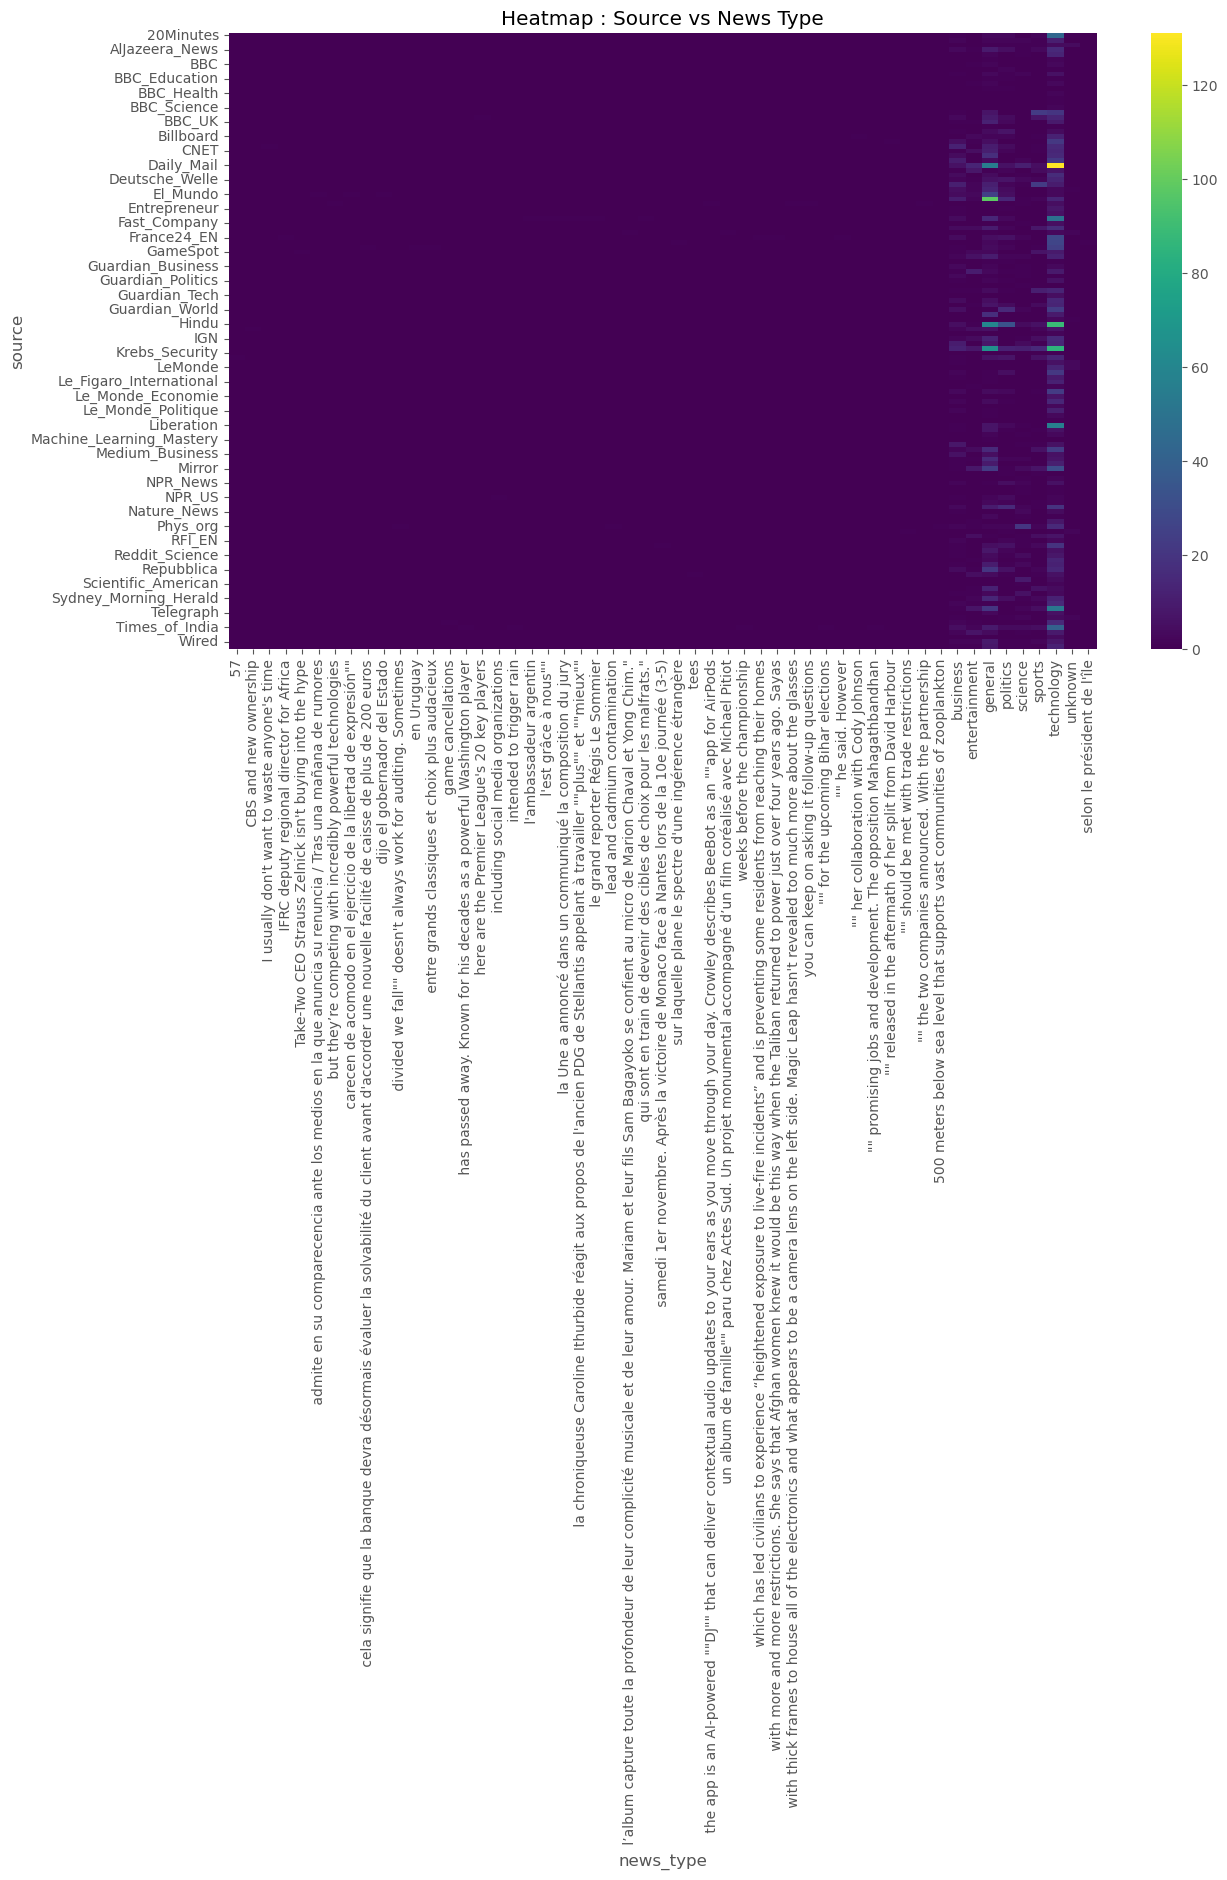

In [94]:
pivot = pdf.pivot_table(
    index='source',
    columns='news_type',
    aggfunc='size',
    fill_value=0
)

plt.figure(figsize=(14,8))
sns.heatmap(pivot, cmap='viridis')
plt.title("Heatmap : Source vs News Type")
plt.show()
